# Less-Referenced Mosaic Testing

This notebook provides a cross-section of the Less-Referenced Mosaic creation process.

# Setup

## Imports

In [1]:
import copy
import glob
import inspect
import os
import shutil

In [2]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import check_random_state
import yaml

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_style('white')

In [4]:
from night_horizons import utils, preprocess, reference, mosaic, raster, pipelines, features

## Settings

In [5]:
with open('./config.yml', "r", encoding='UTF-8') as file:
    settings = yaml.load(file, Loader=yaml.FullLoader)

In [6]:
local_settings = {
    'include_raw_images': True,
    'mosaic_filepath': 'mosaics/less_referenced_test.tiff',
    'random_state': 1682142,
    'train_size': {
        0: 0,
        1: 1,
        2: 0,
    },
    'n_loops': 10,
    'save_bad_images': True,
    'bad_images_dir': '../test_data/feature_matching/',

    'image_joiners_options': {
        'defaults': {
            'feature_detector': 'AKAZE',
            'feature_matcher': 'BFMatcher',
            'log_keys': ['dst_kp', 'dst_pts', 'src_kp', 'src_pts', 'mask', 'abs_det_M'],
            'debug_mode': True,
        },
        'variations': [
            {'n_matches_used': 100, },
        ],
    },

    'padding': 2.,
    'use_approximate_georeferencing': True,
    # This set of choices assumes we have really good starting positions.
    # This is useful for debugging.
    # 'padding': 0.1,
    # 'use_approximate_georeferencing': False,

    # The fraction of non-nan georeferencings required to claim success.
    # We only require a bare minimum here. Performance beyond approximate
    # functionality should be evaluated elsewhere
    'acceptance_fraction': 0.8,

    # These values will be logged and checked for consistency.
    'log_keys': ['x_off', 'y_off', 'x_size', 'y_size', 'dst_img', 'dst_kp', 'src_kp', 'abs_det_M', 'return_code'],
}
settings.update(local_settings)

## Parse Settings

In [7]:
settings['mosaic_filepath'] = os.path.join(settings['data_dir'], settings['mosaic_filepath'])

In [8]:
for key, relpath in settings['paths_relative_to_data_dir'].items():
    settings[key] = os.path.join(settings['data_dir'], relpath)

In [9]:
random_state = check_random_state(settings['random_state'])

In [10]:
palette = sns.color_palette(settings['color_palette'])

In [11]:
crs = settings['crs']

In [12]:
constructor_kwargs = dict(
    image_joiner=features.ImageJoinerQueue(**settings['image_joiners_options']),
    filepath=settings['mosaic_filepath'],
    padding=settings['padding'],
    file_exists='overwrite',
    log_keys=settings['log_keys'],
    crs=crs,
    debug_mode=True,
    bad_images_dir=settings['bad_images_dir'],
)

# Prepare Data
The first part is to prepare the data (AKA extract/transform/load).

## Get filepaths

In [13]:
# Get the referenced filepaths, divided according to camera number
referenced_fps = {i: utils.discover_data(settings['referenced_images_dir'], ['tif', 'tiff'], pattern=r'Geo\s\d+_' + f'{i}.tif') for i in range(3)}

In [14]:
raw_fps = utils.discover_data(settings['images_dir'], ['tif', 'tiff', 'raw'])

## Train-Test Split

We split the data into training data (data that is georeferenced) and test data (data that is not georeferenced, or for which we don't use the georeferencing information when we're building the models).

We set the train size to some small number, because ideally the user only needs to georeference a couple of images manually.

In [15]:
# Get the training sample for each camera
referenced_fps_train = []
referenced_fps_test = []
for camera_num, train_size_i in settings['train_size'].items():

    # When there's no training for this camera
    if train_size_i == 0:
        referenced_fps_test.append(referenced_fps[camera_num])
        continue
        
    referenced_fps_train_i, referenced_fps_test_i = train_test_split(
        referenced_fps[camera_num],
        train_size=train_size_i,
        random_state=settings['random_state'],
        shuffle=True,
    )
    referenced_fps_train.append(referenced_fps_train_i)
    referenced_fps_test.append(referenced_fps_test_i)


In [16]:
referenced_fps_train = pd.concat(referenced_fps_train, ignore_index=True)
referenced_fps_test = pd.concat(referenced_fps_test, ignore_index=True)

## Combine Referenced and Raw

In [17]:
# Adjust the index so we don't have duplicates
raw_fps.index += referenced_fps_test.size

In [18]:
# Actual combination
fps_train = referenced_fps_train
fps_test = referenced_fps_test
if settings['include_raw_images']:
    fps = pd.concat([referenced_fps_test, raw_fps])
else:
    fps = referenced_fps_test

In [19]:
# Expected number of training files
assert len(pd.unique(referenced_fps_train.index)) == np.sum(list(settings['train_size'].values()))
# Consistent indices for test set
assert len(pd.unique(referenced_fps_test.index)) == len(referenced_fps_test.index)

## Preprocessing

### y values
We get the y-values first because we use a model fitted to them to get the X values

In [20]:
preprocessing_pipeline_y = preprocess.GeoTIFFPreprocesser(crs=crs)

In [21]:
# Get the geo-transforms used for training
y_train = preprocessing_pipeline_y.fit_transform(fps_train)
y_test = preprocessing_pipeline_y.fit_transform(fps_test)

100%|████████████████████████████████████████| 160/160 [00:00<00:00, 196.82it/s]


### X values
We use the sensor (high-altitude balloon) positions to provide approximate georeferencing, which will be useful for saving computational time when building the unreferenced mosaic.

In [22]:
# This is the pipeline for approximate georeferencing
preprocessing_steps = pipelines.PreprocessingPipelines.nitelite_preprocessing_steps(
    crs=crs,
    use_approximate_georeferencing=settings['use_approximate_georeferencing'],
)
preprocessing_pipeline = Pipeline(preprocessing_steps)
preprocessing_pipeline

Pipeline(steps=[('metadata', NITELitePreprocesser()),
                ('select_deployment_phase', AltitudeFilter(column='mAltitude')),
                ('select_steady',
                 SteadyFilter(columns=['imuGyroX', 'imuGyroY', 'imuGyroZ'])),
                ('georeference',
                 SensorGeoreferencer(passthrough=['filepath', 'camera_num'])),
                ('order', SensorAndDistanceOrder())])

In [23]:
# Fit the pipeline
preprocessing_pipeline = preprocessing_pipeline.fit(
    fps_train,
    y_train,
    metadata__img_log_fp=settings['img_log_fp'],
    metadata__imu_log_fp=settings['imu_log_fp'],
    metadata__gps_log_fp=settings['gps_log_fp'],
)

In [24]:
# Get out the X values we'll use for the mosaic
X_train = preprocessing_pipeline.transform(fps_train)
X = preprocessing_pipeline.transform(fps)

/Users/Shared/repos/night-horizons-mapmaker/night_horizons/preprocess.py:152: UserWarning: Did not successfully correlate all filepaths. n_uncorrelated = 2
  warnings.warn(w_message)


In [25]:
# Check the camera numbers
for camera_num in range(3):
    assert (X_train['camera_num'] == camera_num).sum() == settings['train_size'][camera_num], 'Camera numbers are not as expected'

In [26]:
# Check the order
np.testing.assert_allclose(X['order'], np.arange(len(X)))
assert X.loc[X['camera_num'] == 1, 'order'].max() < X.loc[X['camera_num'] == 0, 'order'].min(), 'Some camera 1 images come before camera 0 images.'
assert (np.diff(X.loc[X['camera_num'] == 1, 'd_to_center']) < 0).sum() == 0, 'Some smaller distances appear out of order.'

### Check consistency 

In [27]:
# We don't want to drop more than a few files when we're working with the referenced dataset
if not settings['include_raw_images']:
    assert y_test.index.size - X.index.size < 3, 'Too many files dropped.'

In [28]:
fps.index.size

33942

In [29]:
# Drop the y values and filepaths that were filtered out
fps = fps.loc[X.index]
X_test = X.loc[X.index.isin(y_test.index)]
y_test = y_test.loc[X_test.index]

In [30]:
# Check that our test Xs and ys align
n_bad = (y_test['filepath'] != X_test['filepath']).sum()
assert n_bad == 0, f'{n_bad} wrong filepaths'

### Look at Order

/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/Shared/miniconda3/envs/night-horizons/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


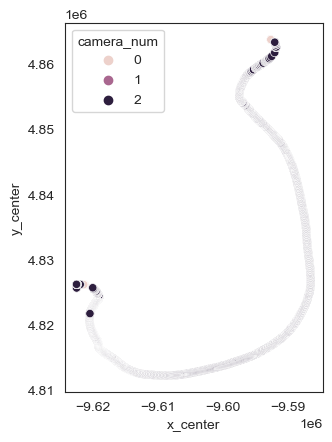

In [31]:
# Let's take a look.
sp = sns.scatterplot(
    data=X,
    x='x_center',
    y='y_center',
    hue='camera_num',
)
sp.set_aspect('equal')

# The Mosaic

### Initialization

#### Test
Check that initialization works, first with a mosaic that only uses the training data.

In [32]:
small_less_reffed_mosaic = mosaic.LessReferencedMosaic(
    dataset_padding=100.,
    **constructor_kwargs
)

In [33]:
small_less_reffed_mosaic.fit(
    X=y_train,
    approx_y=y_train,
)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  7.93it/s]


In [34]:
# The full mosaic image that's saved
mosaic_img = small_less_reffed_mosaic.dataset_.ReadAsArray().transpose(1, 2, 0)
mosaic_image = raster.ReferencedImage(
    mosaic_img[:, :, :3],
    [small_less_reffed_mosaic.x_min_, small_less_reffed_mosaic.x_max_],
    [small_less_reffed_mosaic.y_min_, small_less_reffed_mosaic.y_max_]
)

In [35]:
# The actual image used to make it
original_image = raster.ReferencedImage.open(y_train.iloc[0]['filepath'])

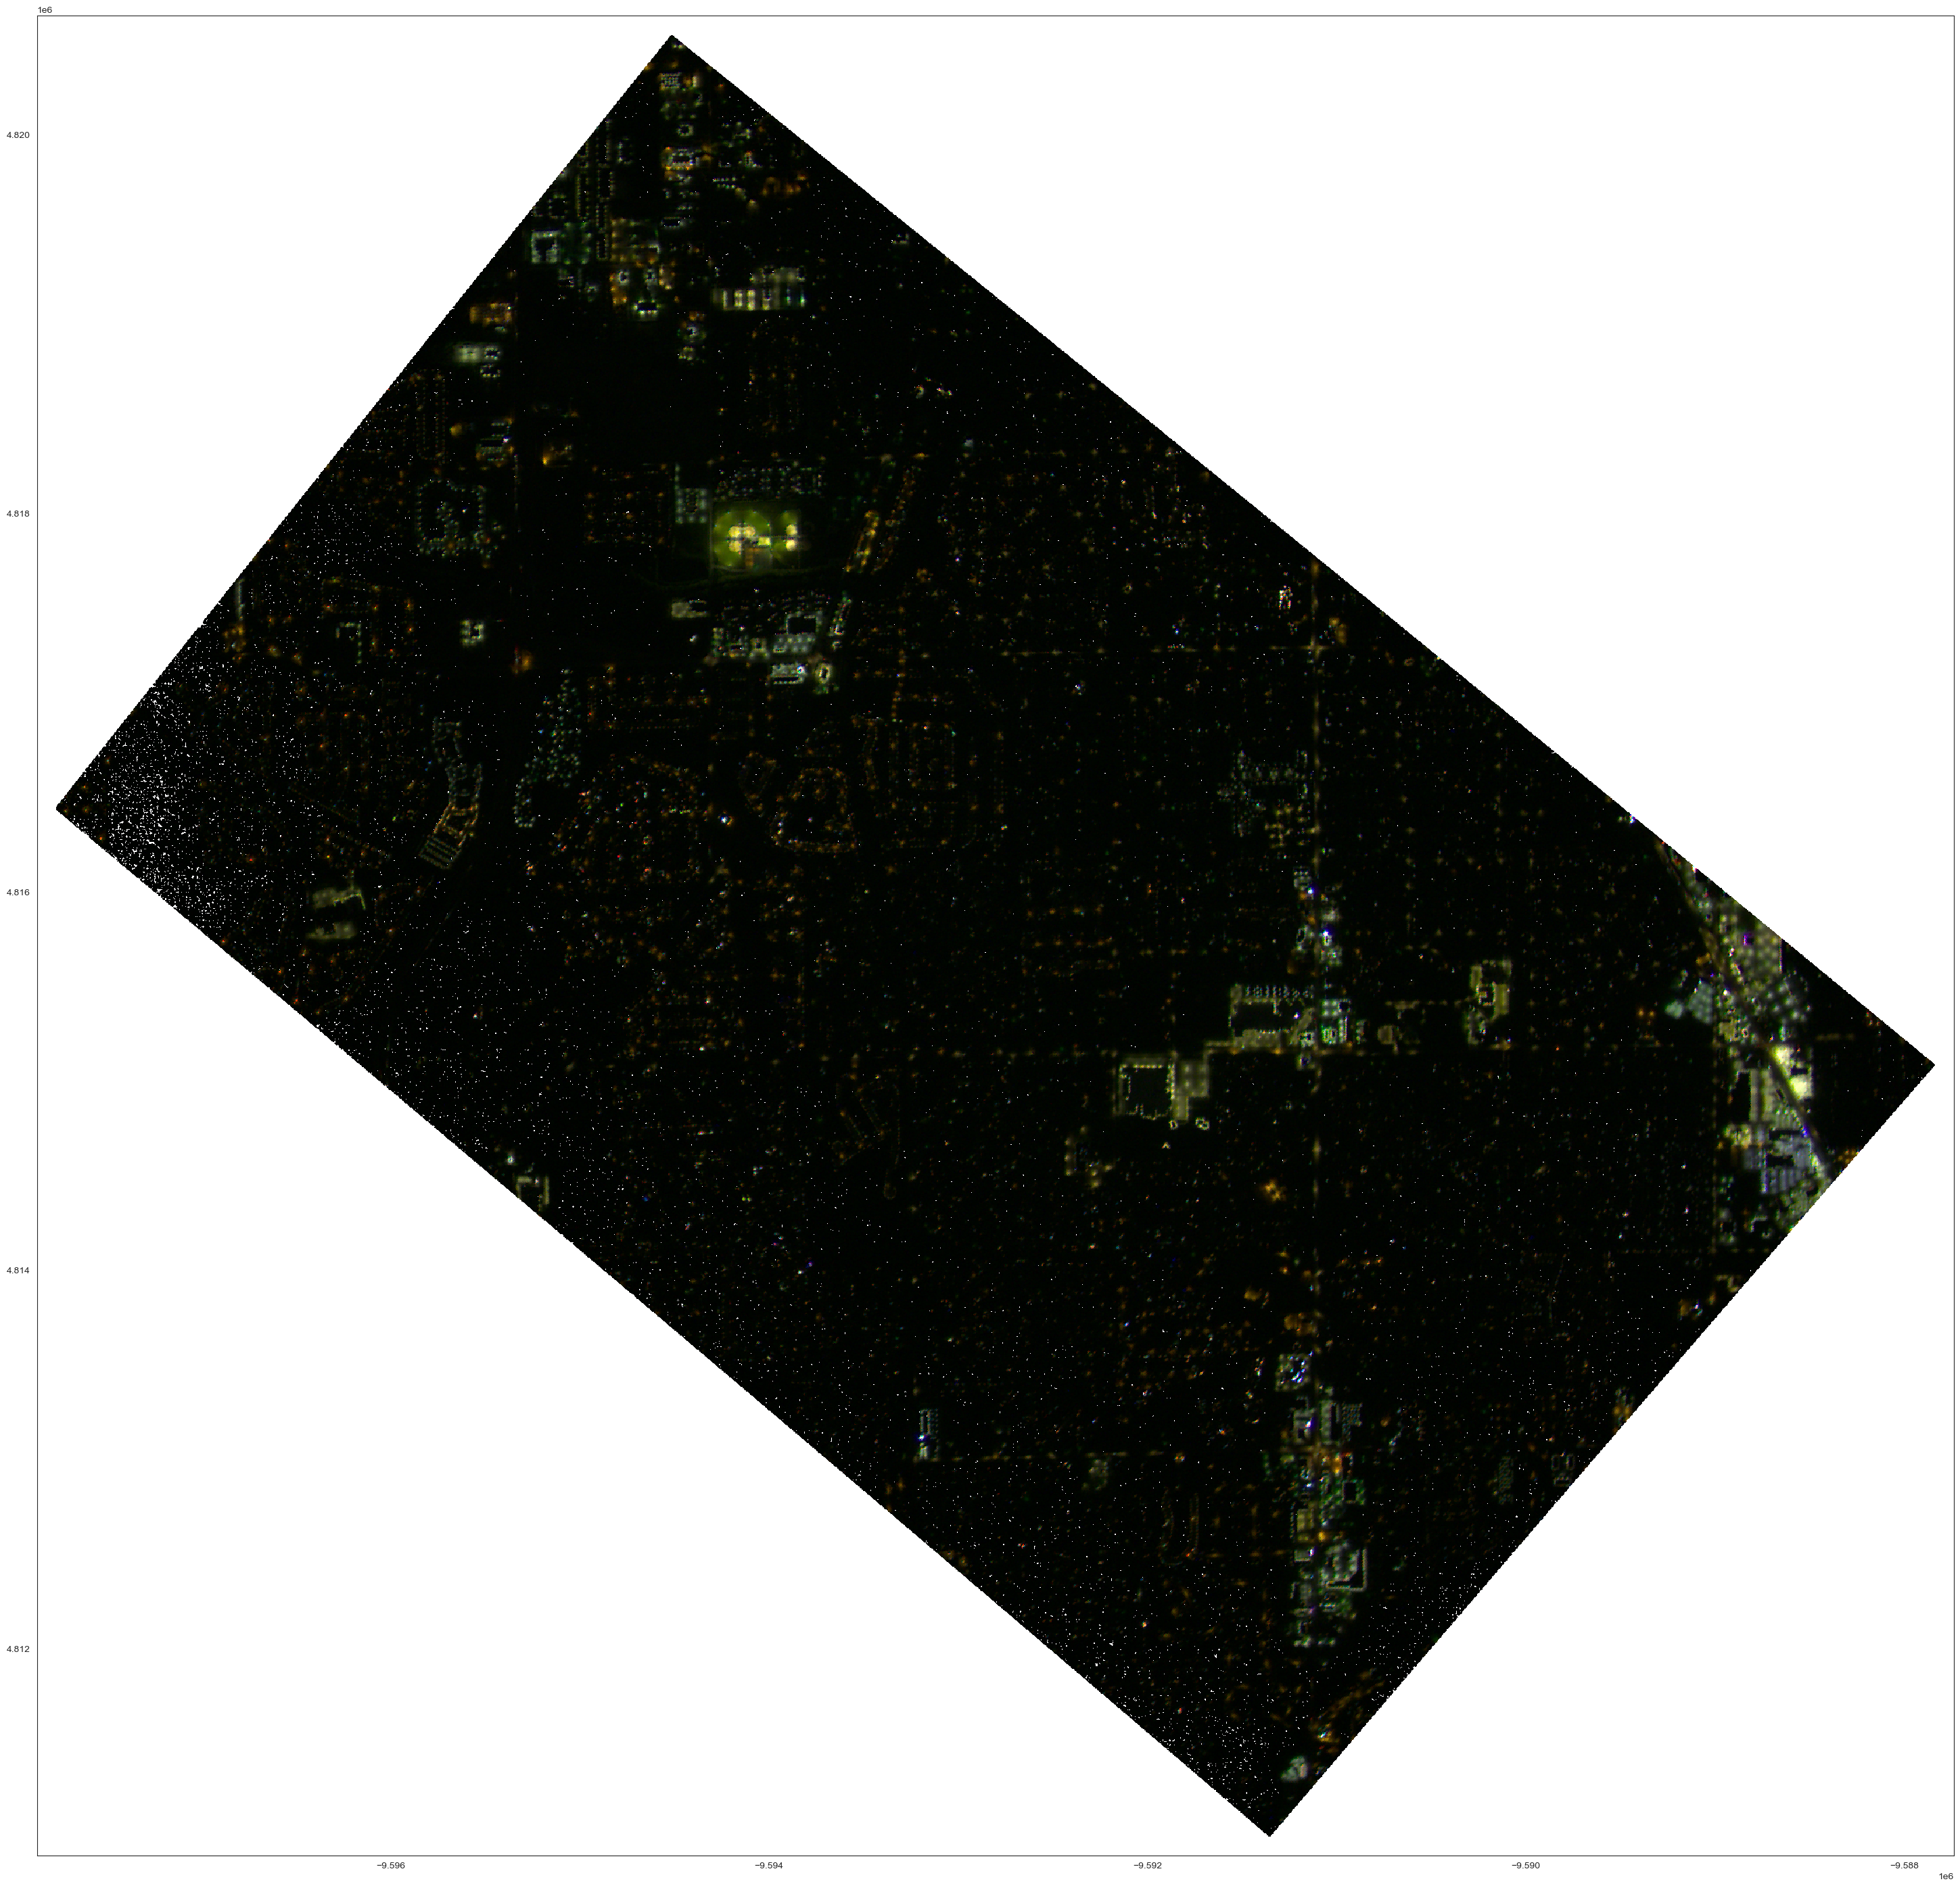

In [36]:
# Compare the mosaic to the actual
mosaic_image.show(crs='cartesian', img='semitransparent_img')

fig = plt.gcf()
ax = plt.gca()

original_image.show(crs='cartesian', img='semitransparent_img', ax=ax)   

In [37]:
# Check the centers
mosaic_center = np.array(mosaic_image.cart_bounds).mean(axis=1)
original_center = np.array(original_image.cart_bounds).mean(axis=1)
d_between_centers = np.linalg.norm(mosaic_center - original_center)
np.testing.assert_allclose(d_between_centers, 0.)

In [38]:
# Check the widths
mosaic_width, mosaic_height = np.diff(mosaic_image.cart_bounds, axis=1).flatten()
original_width, original_height = np.diff(original_image.cart_bounds, axis=1).flatten()
np.testing.assert_allclose(mosaic_width, original_width + 2. * small_less_reffed_mosaic.dataset_padding)
np.testing.assert_allclose(mosaic_height, original_height + 2. * small_less_reffed_mosaic.dataset_padding)

#### Actual full initialization and fit

In [39]:
less_reffed_mosaic = mosaic.LessReferencedMosaic(**constructor_kwargs)

In [40]:
# This creates the dataset and adds the referenced mosaic.
less_reffed_mosaic.fit(
    X=y_train,
    approx_y=X,
)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.27it/s]


#### Validate settings saving

In [41]:
# Open the file
with open(less_reffed_mosaic.settings_filepath_, 'r', encoding='UTF-8') as file:
    saved_settings = yaml.load(file, Loader=yaml.BaseLoader)

In [42]:
# Check that all the values exist
fullargspec = inspect.getfullargspec(mosaic.LessReferencedMosaic.__init__)
expected_args = fullargspec.args
for key in expected_args:
    if key == 'self':
        continue
    assert key in saved_settings, f'attr {key} not found in settings'

## Convert geotransforms to pixel offsets and counts

In [43]:
(
    X['x_off'], X['y_off'],
    X['x_size'], X['y_size']
) = less_reffed_mosaic.physical_to_pixel(
    X['x_min'], X['x_max'],
    X['y_min'], X['y_max'],
    padding = less_reffed_mosaic.padding * X['spatial_error']
)

In [44]:
(
    y_train['x_off'], y_train['y_off'],
    y_train['x_size'], y_train['y_size']
) = less_reffed_mosaic.physical_to_pixel(
    y_train['x_min'], y_train['x_max'],
    y_train['y_min'], y_train['y_max'],
)

## First Image
We'll test the first loop in greater detail than the others.

In [45]:
i = 0
row = X.iloc[i]

In [46]:
mosaic_img = less_reffed_mosaic.dataset_.ReadAsArray().transpose(1, 2, 0)

In [47]:
image_joiner = less_reffed_mosaic.image_joiner.image_joiners[0]

### Search Region in the Context of the Full Mosaic

In [48]:
# Expected bounds
x_off = row['x_off']
y_off = row['y_off']
x_size = row['x_size']
y_size = row['y_size']

In [49]:
(
x_off_nopad, y_off_nopad,
x_size_nopad, y_size_nopad,
) = less_reffed_mosaic.physical_to_pixel(
    row['x_min'], row['x_max'],
    row['y_min'], row['y_max'],
)

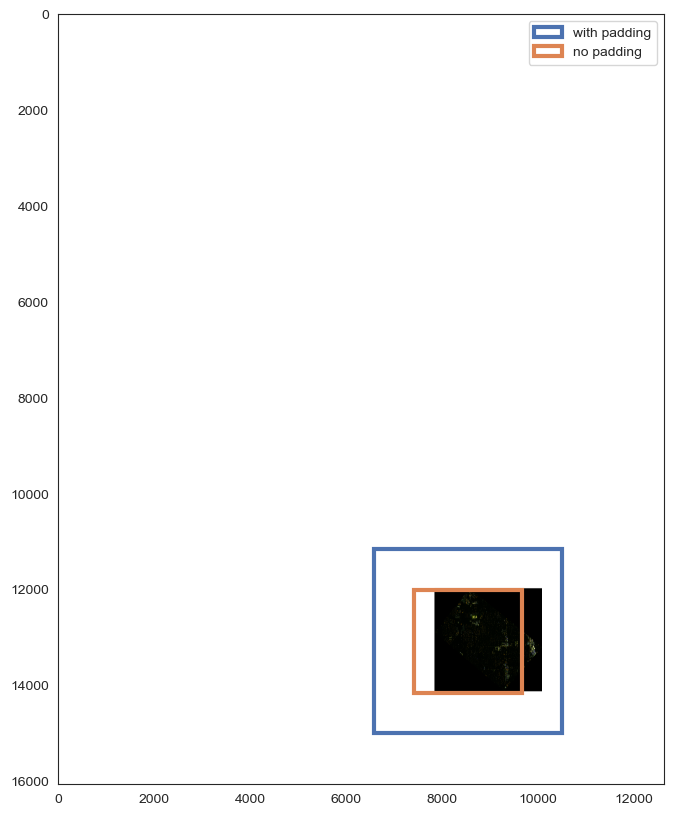

In [50]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()

# Current mosaic
ax.imshow(mosaic_img)

# The first image location
rect = patches.Rectangle(
    (x_off, y_off),
    x_size,
    y_size,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[0],
    label='with padding',
)
ax.add_patch(rect)

# The non-padded first image location
rect = patches.Rectangle(
    (x_off_nopad, y_off_nopad),
    x_size_nopad,
    y_size_nopad,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[1],
    label='no padding',
)
ax.add_patch(rect)

ax.set_aspect('equal')

ax.legend()

### Search Region Image 

In [51]:
# The existing mosaic at this location
dst_img = less_reffed_mosaic.get_image(x_off, y_off, x_size, y_size)

This is plotted below with matched features.

In [52]:
# At this time we expect all data added to the mosaic to be within the bounds of the search region, if we're using approximate georeferencing
if settings['use_approximate_georeferencing']:
    assert dst_img.sum() == mosaic_img.sum()

KeyError: 'use_approximate_georeferencing'

In [ ]:
# Here's a zoomed in version, so we know what we're looking at
row_train = y_train.iloc[0]
zoom_dst_img = less_reffed_mosaic.get_image(
    row_train['x_off'], row_train['y_off'],
    row_train['x_size'], row_train['y_size']
)
plt.imshow(zoom_dst_img)

### Search Region KeyPoints
We get these for later.

In [ ]:
# Get the features from the original mosaic
dst_kp, dst_des = image_joiner.detect_and_compute(dst_img)

In [ ]:
# Transform the dst keypoints to mosaic frame
dst_pts = cv2.KeyPoint_convert(dst_kp)
dsframe_dst_pts = dst_pts + np.array([x_off, y_off])
dsframe_dst_des = copy.copy(dst_des)

In [ ]:
# Look at the image and its keypoints
raster.Image(dst_img).show()

fig = plt.gcf()
ax = plt.gca()

ax.scatter(
    dst_pts[:,0],
    dst_pts[:,1],
    color='none',
    edgecolor='w',
    linewidth=3,
    s=150,
)

### New Image

In [ ]:
src_img = utils.load_image(
    row['filepath'],
    dtype=less_reffed_mosaic.dtype,
)

In [ ]:
src_kp, src_des = image_joiner.detect_and_compute(src_img)
src_pts = cv2.KeyPoint_convert(src_kp)

In [ ]:
# Look at the image and its keypoints
raster.Image(src_img).show()

fig = plt.gcf()
ax = plt.gca()

ax.scatter(
    src_pts[:,0],
    src_pts[:,1],
    color='none',
    edgecolor='w',
    linewidth=3,
    s=150,
)

### Feature Matching

In [ ]:
# Get and validate the transform predicted from feature matching
M = image_joiner.find_homography(src_kp, src_des, dst_kp, dst_des)

In [ ]:
# Inspect relationship
mask = image_joiner.log['mask'].astype(bool)
valid_src_pts = image_joiner.log['src_pts'][mask].reshape((mask.sum(), 2))
valid_dst_pts = image_joiner.log['dst_pts'][mask].reshape((mask.sum(), 2))

In [ ]:
subplot_mosaic = [['dst_img', 'src_img']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['dst_img']
ax.imshow(dst_img)

ax = ax_dict['src_img']
ax.imshow(src_img)

for i in range(valid_src_pts.shape[0]):

    con = patches.ConnectionPatch(
        xyA=valid_dst_pts[i],
        xyB=valid_src_pts[i],
        coordsA='data',
        coordsB='data',
        axesA=ax_dict['dst_img'],
        axesB=ax_dict['src_img'],
        color=palette[1],
        linewidth=3,
    )
    ax.add_artist(con)

In [ ]:
# raster.Image(src_img).save('../test_data/feature_matching/src_0.tiff')
# raster.Image(dst_img).save('../test_data/feature_matching/dst_0.tiff')

In [ ]:
image_joiner.validate_homography(M)

### Warp the Source Image

In [ ]:
# Warp the image being fit
warped_img = image_joiner.warp(src_img, dst_img, M)

In [ ]:
raster.Image(warped_img[:, :, :3]).show(img='semitransparent_img')

In [ ]:
# The warped image should have the same dimensions as the dst img
assert warped_img.shape[:2] == dst_img.shape[:2]

### Blend the images

In [ ]:
blended_img = image_joiner.blend(
    src_img=warped_img,
    dst_img=dst_img,
)

In [ ]:
# Show
raster.Image(blended_img[:, :, :3]).show(img='semitransparent_img')

### Save and look at the mosaic

In [ ]:
less_reffed_mosaic.save_image(blended_img, x_off, y_off)

In [ ]:
# Get the region of just the first image for comparison from before
zoom_dst_img_after = less_reffed_mosaic.get_image(
    row_train['x_off'], row_train['y_off'],
    row_train['x_size'], row_train['y_size'],
)

In [ ]:
# More content should have been added
assert zoom_dst_img_after.sum() > zoom_dst_img.sum()

In [ ]:
# View
subplot_mosaic = [['before', 'after']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['before']
raster.Image(zoom_dst_img[:, :, :3]).show(img='semitransparent_img', ax=ax)

ax = ax_dict['after']
raster.Image(zoom_dst_img_after[:, :, :3]).show(img='semitransparent_img', ax=ax)

### Warp the Keypoints

In [ ]:
# Transform to local frame and then the full mosaic frame
src_pts = cv2.KeyPoint_convert(src_kp)
global_src_pts = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), M).reshape(-1, 2)
global_src_pts += np.array([x_off, y_off])

In [ ]:
# Store the transformed points for the next loop
dsframe_dst_pts = np.append(dsframe_dst_pts, global_src_pts, axis=0)
dsframe_dst_des = np.append(dsframe_dst_des, src_des, axis=0)

In [ ]:
fig = plt.figure()
ax = plt.gca()

sns.scatterplot(
    x=dsframe_dst_pts[:,0],
    y=dsframe_dst_pts[:,1],
    ax = ax,
)

rect = patches.Rectangle(
    (x_off, y_off),
    x_size,
    y_size,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[0],
)
ax.add_patch(rect)

ax.set_xlim(0, less_reffed_mosaic.dataset_.RasterXSize)
ax.set_ylim(less_reffed_mosaic.dataset_.RasterYSize, 0)
ax.set_aspect('equal')

In [ ]:
# Automated check that everything's in bounds
not_in_bounds = ~(
    (x_off <= dsframe_dst_pts[:,0] )
    & (dsframe_dst_pts[:,0] <= x_off + x_size)
    & (y_off <= dsframe_dst_pts[:,1] )
    & (dsframe_dst_pts[:,1] <= y_off + y_size)
)
assert not_in_bounds.sum() == 0

### Check the georeferencing

In [ ]:
# Call the fn
warped_x_off, warped_y_off, warped_x_size, warped_y_size = image_joiner.warp_bounds(src_img, M)
warped_x_off += x_off
warped_y_off += y_off

In [ ]:
# Convert to physical
warped_x_min, warped_x_max, warped_y_min, warped_y_max = less_reffed_mosaic.pixel_to_physical(
    warped_x_off, warped_y_off, warped_x_size, warped_y_size)

In [ ]:
warped_center = np.array([
    0.5 * (warped_x_min + warped_x_max),
    0.5 * (warped_y_min + warped_y_max),
])

In [ ]:
# Compare to recorded
if not settings['include_raw_images']:

    # Get the recorded bounds
    recorded_x_min, recorded_x_max, recorded_y_min, recorded_y_max = y_test.loc[row.name, ['x_min', 'x_max', 'y_min', 'y_max']]
    
    # Get the center
    recorded_center = np.array([
        0.5 * (recorded_x_min + recorded_x_max),
        0.5 * (recorded_y_min + recorded_y_max),
    ])
    
    # Check the centers
    assert np.linalg.norm(warped_center - recorded_center) < 500.

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = plt.gca()

# The warped image location
width = warped_x_max - warped_x_min
height = warped_y_max - warped_y_min
rect = patches.Rectangle(
    (warped_x_min, warped_y_min),
    width,
    height,
    linewidth = 3,
    facecolor = 'none',
    edgecolor = palette[0],
)
ax.add_patch(rect)
ax.scatter(
    *warped_center,
    s=100,
    color=palette[0],
)

# The actual image location
if not settings['include_raw_images']:
    rect = patches.Rectangle(
        (recorded_x_min, recorded_y_min),
        recorded_x_max - recorded_x_min,
        recorded_y_max - recorded_y_min,
        linewidth = 3,
        facecolor = 'none',
        edgecolor = palette[1],
    )
    ax.add_patch(rect)
    ax.scatter(
        *recorded_center,
        s=100,
        color=palette[1],
    )

padding_for_this_plot = 0.1 * width
ax.set_xlim(warped_x_min - padding_for_this_plot, warped_x_max + padding_for_this_plot)
ax.set_ylim(warped_y_min - padding_for_this_plot, warped_y_max + padding_for_this_plot)

ax.set_aspect('equal')

### Log Values

In [ ]:
# Store for later comparison
less_reffed_mosaic.update_log(locals())
less_reffed_mosaic.log.update(image_joiner.log)
less_reffed_mosaic.log['return_code'] = 'success'
for log_key in less_reffed_mosaic.log_keys:
    assert not isinstance(less_reffed_mosaic.log[log_key], list)

In [ ]:
fit_values = {
    key: getattr(less_reffed_mosaic, key)
    for key in less_reffed_mosaic.__dir__()
    if key[-1] == '_' if isinstance(getattr(less_reffed_mosaic, key), float)
}

## Next Image

In [ ]:
i = 1
row1 = X.iloc[i]

### Preview keypoint selection

In [ ]:
x_off1 = row1['x_off']
y_off1 = row1['y_off']
x_size1 = row1['x_size']
y_size1 = row1['y_size']

In [ ]:
in_bounds1 = less_reffed_mosaic.check_bounds(
    dsframe_dst_pts,
    x_off1, y_off1, x_size1, y_size1,
)

In [ ]:
assert in_bounds1.sum() > 0, \
    f'No image data in the search zone for index {row.name}'

In [ ]:
dst_pts1 = dsframe_dst_pts[in_bounds1]
dst_des1 = dsframe_dst_des[in_bounds1]

In [ ]:
# At this point in the loops, *all* the points should be in bounds, if we're doing approximate georeferencing
if settings['use_approximate_georeferencing']:
    assert (~in_bounds1).sum() == 0

### Call the typical function

In [ ]:
if less_reffed_mosaic.feature_mode == 'recompute':
    dsframe_dst_pts = None
    dsframe_dst_des = None

In [ ]:
# DEBUG
# src_image = raster.Image.open(row1['filepath'])
# image_joiner.validate_brightness(src_image.img_int)
# src_image.show()

In [ ]:
return_code, results1 = less_reffed_mosaic.incorporate_image(
    row1,
    dsframe_dst_pts,
    dsframe_dst_des,
)

In [ ]:
assert return_code == 'success', 'Image was not successfully combined.'

In [ ]:
zoom_dst_img_after2 = less_reffed_mosaic.get_image(
    row_train['x_off'], row_train['y_off'],
    row_train['x_size'], row_train['y_size'],
)

In [ ]:
subplot_mosaic = [['before', 'after']]
fig = plt.figure(figsize=(20,10))
ax_dict = fig.subplot_mosaic(subplot_mosaic)

ax = ax_dict['before']
raster.Image(zoom_dst_img_after[:, :, :3]).show(img='semitransparent_img', ax=ax)

ax = ax_dict['after']
raster.Image(zoom_dst_img_after2[:, :, :3]).show(img='semitransparent_img', ax=ax)

## Run for a Subset

Now we'll check if it runs for a subset

In [ ]:
import importlib
importlib.reload(mosaic)

In [ ]:
i = 0
n_loops = settings['n_loops']

In [ ]:
# The actual calls
lr_mosaic = mosaic.LessReferencedMosaic(**constructor_kwargs)

lr_mosaic.fit(
    X=y_train,
    approx_y=X,
)

y_pred = lr_mosaic.predict(
    X.iloc[:n_loops],
)

lr_mosaic.close()

In [ ]:
# Check for consistency for fit values
for key, value in fit_values.items():
    np.testing.assert_allclose(value, getattr(lr_mosaic, key))

In [ ]:
# Check for consistency for calculated values
for log_key in lr_mosaic.log_keys:

    actual = lr_mosaic.log[log_key][:2]
    expected = less_reffed_mosaic.log[log_key][:2]
    
    print(log_key)
    
    try:
        np.testing.assert_allclose(actual, expected)
    except ValueError:
        for j, actual_j in enumerate(actual):
            try:
                np.testing.assert_allclose(actual_j, expected[j])
            except TypeError:
                actual_j = cv2.KeyPoint_convert(actual_j)
                expected_j = cv2.KeyPoint_convert(expected[j])
                np.testing.assert_allclose(actual_j, expected_j)   
    except np.exceptions.DTypePromotionError:
        for j, actual_j in enumerate(actual):
            assert actual_j == expected[j]

In [ ]:
return_codes = pd.Series(lr_mosaic.log['return_code'])
assert len(return_codes) == n_loops, f'More return codes than loops. {n_loops} loops, {len(return_codes)} return codes'

In [ ]:
# Check how many were successful
n_good = (return_codes == 'success').sum()
n_bad = n_loops - n_good
assert n_good / n_loops > settings['acceptance_fraction'], \
    (
        f"{n_bad} failures, success rate of {settings['acceptance_fraction']} not met. "
        f'Return codes are...\n{return_codes}'
    )

In [ ]:
assert y_pred.index.isin(y_test.index).sum() > 0, 'No points of comparison available.'

In [ ]:
# Merge into a comparison dataframe
y_pred_for_eval = y_pred.reindex(y_test.index)

In [ ]:
# Estimate the consistency with the manual geotransforms
y_err = y_test - y_pred_for_eval
err = np.sqrt(y_err['x_min']**2. + y_err['y_max']**2.)

In [ ]:
# Check how bad the errors are
n_egregious = (err > 300.).sum()
assert n_egregious == 0, f'Found {n_egregious} egregious errors.'

In [ ]:
# Visualize the errors
fig = plt.figure()
ax = plt.gca()

sns.scatterplot(
    x=np.arange(y_err.index.size),
    y=err,
    hue=np.arange(len(y_err)),
    ax=ax,
)

ax.set_ylim(0, ax.get_ylim()[1])

# DEBUG

## Check georeferencing (DEBUG)
The below doesn't really make sense, because the x_off, y_off, x_size, y_size that are warped are really unreliable for the image itself.
Only some parts (e.g. the image center) are trustworthy-ish.

In [ ]:
# # Get the warped bounds
# (
#     warped_x_min, warped_x_max,
#     warped_y_min, warped_y_max,
# ) = less_reffed_mosaic.pixel_to_physical(
#     info['x_off'], info['y_off'],
#     info['x_size'], info['y_size'],
# )

In [ ]:
# # Get the centers
# warped_center = np.array([
#     0.5 * (warped_x_min + warped_x_max),
#     0.5 * (warped_y_min + warped_y_max),
# ])

In [ ]:
# if not settings['include_raw_images']:

#     # Get the recorded bounds
#     recorded_x_min, recorded_x_max, recorded_y_min, recorded_y_max = y_test.loc[row.name, ['x_min', 'x_max', 'y_min', 'y_max']]
    
#     recorded_center = np.array([
#         0.5 * (recorded_x_min + recorded_x_max),
#         0.5 * (recorded_y_min + recorded_y_max),
#     ])
    
#     # Check the centers
#     d_between_centers = np.linalg.norm(warped_center - recorded_center)
#     assert d_between_centers < 100.

#     src_image = raster.ReferencedImage.open(row['filepath'])

In [ ]:
# blended_img = less_reffed_mosaic.get_image(row['x_off'], row['y_off'], row['x_size'], row['y_size'])
# blended_image = raster.ReferencedImage(blended_img[:, :, :3], [warped_x_min, warped_x_max], [warped_y_min, warped_y_max])

In [ ]:
# fig = plt.figure(figsize=(20,10))
# ax = plt.gca()

# blended_image.show(crs='cartesian', img='semitransparent_img', ax=ax)

# if not settings['include_raw_images']:
#     src_image.show(crs='cartesian', iimg='semitransparent_img', ax=ax)

# # The warped image location
# width = warped_x_max - warped_x_min
# height = warped_y_max - warped_y_min
# rect = patches.Rectangle(
#     (warped_x_min, warped_y_min),
#     width,
#     height,
#     linewidth = 3,
#     facecolor = 'none',
#     edgecolor = palette[0],
# )
# ax.add_patch(rect)
# ax.scatter(
#     *warped_center,
#     s=100,
#     color=palette[0],
#     label='found',
# )

# # The actual image location
# if not settings['include_raw_images']:
#     rect = patches.Rectangle(
#         (recorded_x_min, recorded_y_min),
#         recorded_x_max - recorded_x_min,
#         recorded_y_max - recorded_y_min,
#         linewidth = 3,
#         facecolor = 'none',
#         edgecolor = palette[1],
#     )
#     ax.add_patch(rect)
#     ax.scatter(
#         *recorded_center,
#         s=100,
#         color=palette[1],
#         label='recorded',
#     )

# padding_for_this_plot = 0.1 * width
# ax.set_xlim(warped_x_min - padding_for_this_plot, warped_x_max + padding_for_this_plot)
# ax.set_ylim(warped_y_min - padding_for_this_plot, warped_y_max + padding_for_this_plot)

# ax.set_aspect('equal')
# ax.legend()